# Prediction

- **Mouse ID**: m01_d2
- **Predicting**: Neural data (PC1)
- **Predictor**: SimCLR layerwise features (reduced to various numbers of PCs)
- **Plotting**: SimCLR layerwise mean FEV vs. number of feats PCs used (line)
- **Plotting**: SimCLR mean FEV for each layer with best performing number of PCs (bar)

In [1]:
from cortexlib.utils import file as futils
from cortexlib.mouse import CortexlabMouse
from cortexlib.images import CortexlabImages
from cortexlib.simclr import PreTrainedSimCLRModel
from cortexlib.predictor import NeuralResponsePredictor
from cortexlib.utils.plotting import simclr_colours
from cortexlib.utils.random import set_global_seed
from cortexlib.utils.logging import Logger
import matplotlib.pyplot as plt
import pandas as pd

logger = Logger()
set_global_seed()

In [2]:
MOUSE_ID = futils.get_mouse_id()
logger.info(f"This notebook is running for mouse {MOUSE_ID}")

14:56:00 | INFO     | ℹ️ This notebook is running for mouse m01_d2


In [3]:
mouse = CortexlabMouse(mouse_id=MOUSE_ID)

logger.progress(f"Computing null distributions for all neurons for mouse {mouse.id}")
null_srv_all_neurons = mouse.compute_null_all_neurons(n_shuffles=100)
logger.success(f"Null distributions computed")

real_srv_all_neurons = mouse.compute_real_srv_all_neurons()
reliable_neuron_indices = mouse.get_reliable_neuron_indices(
            null_srv_all_neurons, real_srv_all_neurons, percentile_threshold=99)
neural_responses_mean, neural_responses, _ = mouse.get_responses_for_reliable_neurons(reliable_neuron_indices, real_srv_all_neurons, num_neurons=500)

logger.info(f"Neural responses shape: {neural_responses.shape}")

14:56:01 | INFO     | ⏳ Computing null distributions for all neurons for mouse m01_d2...
14:56:26 | SUCCESS  | ✅ Null distributions computed!
14:56:26 | INFO     | ℹ️ Neural responses shape: (1380, 2, 500)


In [4]:
futils.save_filtered_neural_data(
    mouse_id=mouse.id,
    neural_responses=neural_responses,
    neural_responses_mean=neural_responses_mean)

14:56:26 | INFO     | ℹ️ Skipping save, file already exists at /Users/callummessiter/workspace/msc-neuro/research-project/analysis/mouse_m01_d2/_neural_data/neural_data_mouse_m01_d2.pt


In [5]:
simclr = PreTrainedSimCLRModel()

settings = simclr.get_image_settings()
images = CortexlabImages(
    size=settings['size'],
    channels=settings['channels'],
    normalise_mean=settings['mean'], 
    normalise_std=settings['std'],
    rescale_per_image=settings['rescale_per_image'],
)

logger.progress("Loading and preprocessing images shown to mouse")
image_dataset = images.load_images_shown_to_mouse(mouse.image_ids)
logger.success("Images processed")

14:56:26 | INFO     | ℹ️ Already downloaded pretrained SimCLR model
14:56:26 | INFO     | ⏳ Loading and preprocessing images shown to mouse...
14:56:43 | SUCCESS  | ✅ Images processed!


In [6]:
logger.progress("SimCLR: extracting features from images shown to mouse")
simclr_feats, labels = simclr.extract_features(image_dataset)
logger.success("SimCLR features extracted")

for layer, feats in simclr_feats.items():
    logger.info(f"{layer} feats shape: {tuple(feats.shape)}")

14:56:43 | INFO     | ⏳ SimCLR: extracting features from images shown to mouse...


  0%|          | 0/22 [00:00<?, ?it/s]

14:56:56 | SUCCESS  | ✅ SimCLR features extracted!
14:56:56 | INFO     | ℹ️ layer1 feats shape: (1380, 64, 24, 24)
14:56:56 | INFO     | ℹ️ layer2 feats shape: (1380, 128, 12, 12)
14:56:56 | INFO     | ℹ️ layer3 feats shape: (1380, 256, 6, 6)
14:56:56 | INFO     | ℹ️ layer4 feats shape: (1380, 512, 3, 3)
14:56:56 | INFO     | ℹ️ fc feats shape: (1380, 512)


In [7]:
futils.save_model_features(model=futils.Model.SIMCLR, mouse_id=mouse.id, features=simclr_feats, labels=labels)

14:56:56 | INFO     | ℹ️ Skipping save, file already exists at /Users/callummessiter/workspace/msc-neuro/research-project/analysis/mouse_m01_d2/_model_features/simclr_features_mouse_m01_d2.pt


In [8]:
# Compute test-train split indexes just once - and apply both to all layers
logger.progress("Computing test/train split for regression: SimCLR Feats => Neural Data")

num_images = simclr_feats['layer1'].shape[0]
split = NeuralResponsePredictor.get_train_test_indexes(num_images)
logger.success(f"Computed train/test split")

14:56:56 | INFO     | ⏳ Computing test/train split for regression: SimCLR Feats => Neural Data...
14:56:56 | SUCCESS  | ✅ Computed train/test split!


In [9]:
fev_results = []

logger.progress("Running regressions: SimCLR Feats => PC1 Neural Data")
for layer, feats in simclr_feats.items():
    logger.progress(f"SimCLR {layer}")
    
    for n_pcs in [None, 10, 20, 50, 100, 200, 300, 400, 500]:
        predictor = NeuralResponsePredictor(
            reduce_image_representation_to_n_pcs=n_pcs, 
            neural_data_pc_index=0,
            train_idx=split['train_idx'],
            test_idx=split['test_idx'],
        )
        fev = predictor.compute_fev(feats, neural_responses)

        fev_results.append({
            'layer': layer,
            'n_pcs': n_pcs,
            'test_r2': fev['test_r2'],
            'mean_fev': fev['mean_fev']
        })

logger.success(f"Regressions complete")

14:56:56 | INFO     | ⏳ Running regressions: SimCLR Feats => PC1 Neural Data...
14:56:56 | INFO     | ⏳ SimCLR layer1...
14:58:15 | INFO     | ⏳ SimCLR layer2...
14:58:58 | INFO     | ⏳ SimCLR layer3...
14:59:23 | INFO     | ⏳ SimCLR layer4...
14:59:36 | INFO     | ⏳ SimCLR fc...
14:59:40 | SUCCESS  | ✅ Regressions complete!


In [10]:
futils.write_json_file(fev_results, f'./prediction.json')

In [11]:
fev_results_df = pd.DataFrame(fev_results)
fev_results_df.head(12)

,layer,n_pcs,test_r2,mean_fev
0,layer1,NaN,0.434855,0.459681
1,layer1,10.0,0.403972,0.427305
2,layer1,20.0,0.442110,0.467287
3,layer1,50.0,0.430987,0.455626
4,layer1,100.0,0.425391,0.449759
5,layer1,200.0,0.422741,0.446981
6,layer1,300.0,0.424424,0.448746
7,layer1,400.0,0.427902,0.452392
8,layer1,500.0,0.432053,0.456744
9,layer2,NaN,0.465730,0.492048


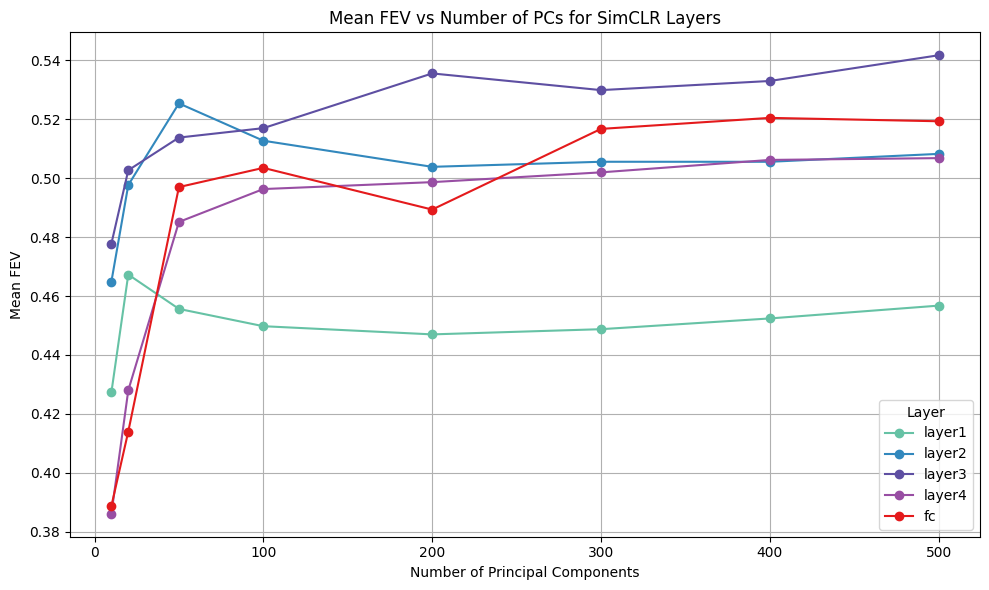

In [12]:
plt.figure(figsize=(10, 6))

for layer in fev_results_df['layer'].unique():
    layer_results = fev_results_df[fev_results_df['layer'] == layer]
    plt.plot(layer_results['n_pcs'], layer_results['mean_fev'], marker='o', color=simclr_colours[layer], label=layer)

plt.xlabel('Number of Principal Components')
plt.ylabel('Mean FEV')
plt.title('Mean FEV vs Number of PCs for SimCLR Layers')
plt.legend(title='Layer')
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
best_fev_per_layer = fev_results_df.loc[fev_results_df.groupby("layer")["mean_fev"].idxmax()]
best_fev_per_layer

,layer,n_pcs,test_r2,mean_fev
43,fc,400.0,0.492836,0.520464
2,layer1,20.0,0.442110,0.467287
12,layer2,50.0,0.497531,0.525386
18,layer3,NaN,0.518632,0.547507
27,layer4,NaN,0.482073,0.509181


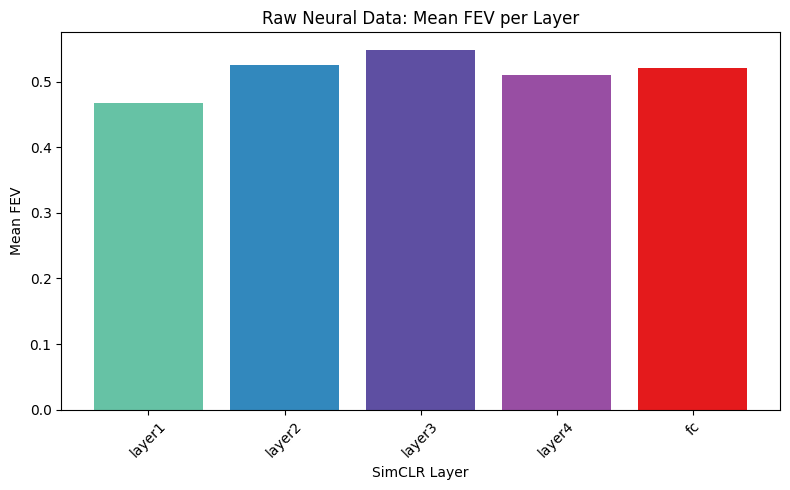

In [14]:
desired_order = simclr_feats.keys()
best_fev_per_layer = best_fev_per_layer.set_index("layer").loc[desired_order].reset_index()
layers = [row["layer"] for _, row in best_fev_per_layer.iterrows()]
mean_fevs = [row["mean_fev"] for _, row in best_fev_per_layer.iterrows()]

colors = [simclr_colours[layer] for layer in layers]

plt.figure(figsize=(8, 5))
plt.bar(layers, mean_fevs, color=colors)
plt.ylabel("Mean FEV")
plt.xlabel("SimCLR Layer")
plt.title("Raw Neural Data: Mean FEV per Layer")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()